<a href="https://colab.research.google.com/github/Arden-Zhu/fashion_net2/blob/master/TryDeepFashion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline


import os
import time
import pandas as pd
import numpy as np
import PIL
from pathlib import Path

In [2]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
from fastai.vision.data import verify_image
from fastai.vision import *

In [4]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
my_drive_dir = "/content/gdrive/My Drive/Machine Learning"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [5]:
since = time.time()

dataset_root = os.path.join(my_drive_dir, 'Datasets\DeepFashion\Category and Attribute Prediction Benchmark'.replace('\\', '/'))
! unzip -q -n '{dataset_root}/Img/img.zip' -d data/
print('%.3f' % (time.time() - since))

94.121


## list_category_img

In [0]:
file = os.path.join(dataset_root, 'Anno/list_category_img.txt')
df = pd.read_fwf(file, skiprows=2, header=None, widths=[71, 2])
df.head()

,0,1
0,img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,3
1,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,3
2,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,3
3,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,3
4,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,3


In [0]:
# verify images
''' 
def verify_images(files=None, delete:bool=True, max_workers:int=4, max_size=None, recurse:bool=False,
                  dest='.', n_channels:int=3, interp=PIL.Image.BILINEAR, ext:str=None, img_format:str=None,
                  resume:bool=None, **kwargs):
    "Check if the images in `path` aren't broken, maybe resize them and copy it in `dest`."
    # path = Path(path)
    if resume is None and dest == '.': resume=False
    dest = Path(dest)
    os.makedirs(dest, exist_ok=True)
    # files = get_image_files(path, recurse=recurse)
    func = partial(verify_image, delete=delete, max_size=max_size, dest=dest, n_channels=n_channels, interp=interp,
                   ext=ext, img_format=img_format, resume=resume, **kwargs)
    parallel(func, files, max_workers=max_workers)

since = time.time()
files = df[0].values
files = ['data/' + f for f in files]
verify_images(files, delete=False)
print(time.time() - since)
'''

' \ndef verify_images(files=None, delete:bool=True, max_workers:int=4, max_size=None, recurse:bool=False,\n                  dest=\'.\', n_channels:int=3, interp=PIL.Image.BILINEAR, ext:str=None, img_format:str=None,\n                  resume:bool=None, **kwargs):\n    "Check if the images in `path` aren\'t broken, maybe resize them and copy it in `dest`."\n    # path = Path(path)\n    if resume is None and dest == \'.\': resume=False\n    dest = Path(dest)\n    os.makedirs(dest, exist_ok=True)\n    # files = get_image_files(path, recurse=recurse)\n    func = partial(verify_image, delete=delete, max_size=max_size, dest=dest, n_channels=n_channels, interp=interp,\n                   ext=ext, img_format=img_format, resume=resume, **kwargs)\n    parallel(func, files, max_workers=max_workers)\n\nsince = time.time()\nfiles = df[0].values\nfiles = [\'data/\' + f for f in files]\nverify_images(files, delete=False)\nprint(time.time() - since)\n'

In [0]:
df[0] = df.apply(lambda m: 'data/' + m[0], axis=1)
df.head()

,0,1
0,data/img/Sheer_Pleated-Front_Blouse/img_000000...,3
1,data/img/Sheer_Pleated-Front_Blouse/img_000000...,3
2,data/img/Sheer_Pleated-Front_Blouse/img_000000...,3
3,data/img/Sheer_Pleated-Front_Blouse/img_000000...,3
4,data/img/Sheer_Pleated-Front_Blouse/img_000000...,3


## ImageDataBunch

In [0]:
bs = 64

In [0]:
transforms = get_transforms()

In [0]:
data = ImageDataBunch.from_df('/content/data/', df, size=224, bs=bs, ds_tfms=transforms
                              ).normalize(imagenet_stats)

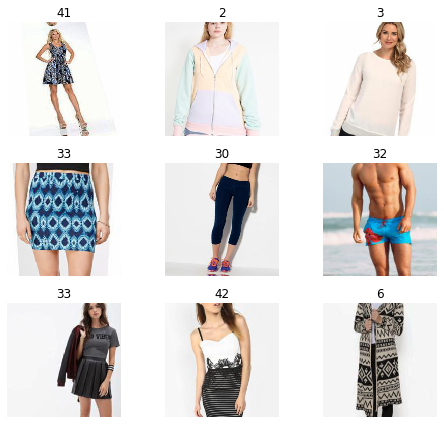

In [0]:
data.show_batch(rows=3, figsize=(7,6))

In [0]:
ds = data.train_ds
len(ds), type(ds)

(231378, fastai.data_block.LabelList)

In [0]:
img, lbl = ds[0]
img.shape, type(img)  

(torch.Size([3, 224, 224]), fastai.vision.image.Image)

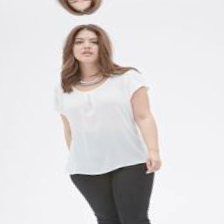

In [0]:
img

In [0]:
dl = data.train_dl
it = iter(dl)
item = it.__next__()

In [0]:
imgs, lbls = item
imgs.shape, lbls.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

In [0]:
img = imgs[0]
img.shape

torch.Size([3, 224, 224])

In [0]:
from torchvision import transforms

class experimental_dataset(Dataset):

    def __init__(self, data, transform):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data.shape[0])

    def __getitem__(self, idx):
        item = self.data[idx]
        item = self.transform(item)
        return item

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

x = torch.rand(2, 1, 2, 2)
print(x)
print('=' * 8)
dataset = experimental_dataset(x,transform)

for item in dataset:
    print(item)
print('=' * 8)
for item in dataset:
    print(item)    

tensor([[[[0.2620, 0.8276],
          [0.7646, 0.2877]]],


        [[[0.7471, 0.1332],
          [0.1655, 0.5580]]]])
tensor([[[0.2588, 0.8275],
         [0.7608, 0.2863]]])
tensor([[[0.7451, 0.1294],
         [0.1647, 0.5569]]])
tensor([[[0.2588, 0.8275],
         [0.7608, 0.2863]]])
tensor([[[0.7451, 0.1294],
         [0.1647, 0.5569]]])


In [0]:
type(ds)

fastai.data_block.LabelList

In [0]:
type(ds[0][0])

fastai.vision.image.Image

## Transforms

In [0]:
df2 = df[:20]
df2.values

array([['data/img/Sheer_Pleated-Front_Blouse/img_00000001.jpg', 3],
       ['data/img/Sheer_Pleated-Front_Blouse/img_00000002.jpg', 3],
       ['data/img/Sheer_Pleated-Front_Blouse/img_00000003.jpg', 3],
       ['data/img/Sheer_Pleated-Front_Blouse/img_00000004.jpg', 3],
       ['data/img/Sheer_Pleated-Front_Blouse/img_00000005.jpg', 3],
       ['data/img/Sheer_Pleated-Front_Blouse/img_00000006.jpg', 3],
       ['data/img/Sheer_Pleated-Front_Blouse/img_00000007.jpg', 3],
       ['data/img/Sheer_Pleated-Front_Blouse/img_00000008.jpg', 3],
       ['data/img/Sheer_Pleated-Front_Blouse/img_00000009.jpg', 3],
       ['data/img/Sheer_Pleated-Front_Blouse/img_00000010.jpg', 3],
       ['data/img/Sheer_Pleated-Front_Blouse/img_00000011.jpg', 3],
       ['data/img/Sheer_Pleated-Front_Blouse/img_00000012.jpg', 3],
       ['data/img/Sheer_Pleated-Front_Blouse/img_00000013.jpg', 3],
       ['data/img/Sheer_Pleated-Front_Blouse/img_00000014.jpg', 3],
       ['data/img/Sheer_Pleated-Front_Blouse/img

In [0]:
tfs =  get_transforms(max_zoom=1.05, max_warp=0.05, max_rotate=5)
tfs[0][0] = crop_pad(row_pct=(0.4, 0.6), col_pct=(0.4, 0.6))
# tfs = (tfs[0][1:], tfs[1])
tfs

([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0.4, 0.6), 'col_pct': (0.4, 0.6)}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmPixel (flip_lr), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.05, 0.05)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-5, 5)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.05), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.4, 0.6)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.8, 1.25)}, p=0.75, resolved={}, do_run=True, is_random=True

In [0]:
# tfs = ([crop_pad()], [crop_pad()])
# tfs =  get_transforms()
data = ImageDataBunch.from_df('/content', df2, size=224, bs=9, ds_tfms=tfs, resize_method=ResizeMethod.CROP #, padding_mode='zeros'
                              ).normalize(imagenet_stats)


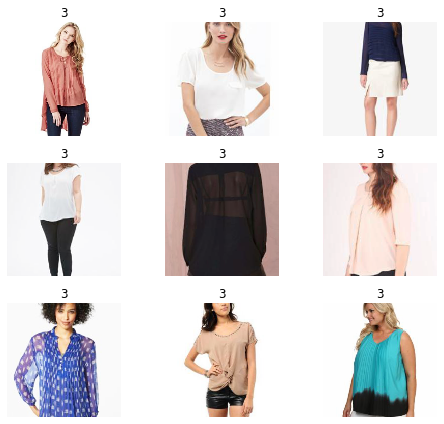

In [0]:
data.show_batch(rows=3, figsize=(7,6))

## list_category_cloth

In [0]:
file = os.path.join(dataset_root, 'Anno/list_category_cloth.txt')
df_category = pd.read_fwf(file, skiprows=2, header=None, widths=[15, 1])
df_category.index += 1
df_category.columns=['category_name', 'category_type']
df_category.tail()

,category_name,category_type
46,Onesie,3
47,Robe,3
48,Romper,3
49,Shirtdress,3
50,Sundress,3


In [0]:
df.columns = ['file', 'category_id']
df3 = df.join(df_category, on='category_id')

In [0]:
df3.loc[df3.category_type != 2]

,file,category_id,category_name,category_type
0,data/img/Sheer_Pleated-Front_Blouse/img_000000...,3,Blouse,1
1,data/img/Sheer_Pleated-Front_Blouse/img_000000...,3,Blouse,1
2,data/img/Sheer_Pleated-Front_Blouse/img_000000...,3,Blouse,1
3,data/img/Sheer_Pleated-Front_Blouse/img_000000...,3,Blouse,1
4,data/img/Sheer_Pleated-Front_Blouse/img_000000...,3,Blouse,1
...,...,...,...,...
289217,data/img/Paisley_Print_Babydoll_Dress/img_0000...,41,Dress,3
289218,data/img/Paisley_Print_Babydoll_Dress/img_0000...,41,Dress,3
289219,data/img/Paisley_Print_Babydoll_Dress/img_0000...,41,Dress,3
289220,data/img/Paisley_Print_Babydoll_Dress/img_0000...,41,Dress,3
